In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import rawpy

In [3]:
import scipy.signal

In [4]:
import glob

In [5]:
import os.path
import exifread

In [6]:
from collections import defaultdict

In [7]:
def load_rgb(path, yrange=None, xrange=None):
    raw = rawpy.imread(path)
    rgb = raw.postprocess(demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR,
                      output_bps=16, no_auto_bright=True, gamma=(2.5,3)).astype('float')

    if xrange and yrange:
        jupiter = rgb[yrange[0]:yrange[1],xrange[0]:xrange[1],:]
    else:
        jupiter = rgb
    return jupiter

def load_lum(path, yrange=None, xrange=None):
    jupiter = load_rgb(path, yrange, xrange)
    def lum(img):
        coeffs = [0.299, 0.587, 0.114 ]

        retval = np.zeros_like(img[:,:,0])
        for i, c_i in enumerate(coeffs):
            retval += c_i * img[:,:,i] # **2

        return retval # np.sqrt(retval)
    return lum(jupiter)

In [8]:
def find_target(x, tdim, downsample):
    # Implements a quick-and-dirty convolution with a tdim x tdim array of ones.
    
    if x.shape[0] <= tdim or x.shape[1] <= tdim:
        return None

    if 1 != downsample:
        ds_retval = find_target(x[::downsample, ::downsample], tdim/downsample, 1)
        return (downsample*ds_retval[0], downsample*ds_retval[1])
    
    sums = np.zeros((x.shape[0]-tdim, x.shape[1]-tdim))
    
    for d0 in range(tdim):
        for d1 in range(tdim):
            sums += x[d0:(d0-tdim),d1:(d1-tdim)]
            
    th = tdim/2
    
    maxloc = np.argmax(sums)
    maxind = np.unravel_index(maxloc, sums.shape)
    
    return (maxind[0]+th, maxind[1]+th)

In [9]:
def find_align(f0, f1,max_dx=30, max_dy=30):
    "Finds a rough alignment between two patches, searchs +/- the max_dx,max_dy ranges"
    
    # Make a little low-pass donut filter
    k = np.zeros((3,3))
    k += 1
    k[1,1] = 0
    k /= np.sum(k)

    # we compute the deltas both ways, then choose the minimum
    deltas01 = np.zeros((max_dy, max_dx))
    deltas10 = np.zeros((max_dy, max_dx))

    f0p = scipy.signal.convolve2d(f0, k, mode='same')
    f1p = scipy.signal.convolve2d(f1, k, mode='same')
    
    for dx in range(max_dx):
        for dy in range(max_dy):

            d = f1p[:-max_dy,:-max_dx] - f0p[dy:(dy-max_dy),dx:(dx-max_dx)]
            deltas10[dy,dx] = np.sqrt(np.sum(d*d))
            
            d = f0p[:-max_dy,:-max_dx] - f1p[dy:(dy-max_dy),dx:(dx-max_dx)]
            deltas01[dy,dx] = np.sqrt(np.sum(d*d))            

    min01 = np.min(deltas01)
    min10 = np.min(deltas10)
    
    if min01 < min10:
        return np.unravel_index(np.argmin(deltas01), deltas01.shape)
    
    minind = np.unravel_index(np.argmin(deltas10), deltas10.shape)
    return (-1*minind[0], -1*minind[1])

In [10]:
def extract_frame(x, t, margin, offset):
    i0 = t[0] + offset[0]
    i1 = t[1] + offset[1]
    
    return x[(i0-margin):(i0+margin),(i1-margin):(i1+margin)]

def load_stack(paths, tdim, margin, downsample=3):
    frames = []

    x = load_lum(paths[0])
    t = find_target(x, tdim, downsample)
    
    frames.append(extract_frame(x, t, margin, (0,0)))
    
    for p in paths[1:]:
        try:
            x = load_lum(p)
            t = find_target(x, tdim, downsample)
            rough_frame = extract_frame(x, t, margin, (0,0))
            o = find_align(frames[0], rough_frame)
            frame = extract_frame(x,t,margin,o)

            rms = np.sqrt(np.sum((frames[0]-frame)**2)/len(frame))

            #print "\tLoaded %s at -%s (t=%s) (RMS %0.2f)" % (p, o, t, rms)

            if False and (p == paths[1]):
                f2 = extract_frame(x,t,margin,(-o[0],-o[1]))
                rms2 = np.sqrt(np.sum((frames[0]-f2)**2)/len(f2))
                print "\tRMS+ = %0.1f, RMS- = %0.1f" % (rms, rms2)

            frames.append(frame.copy()) # copy to remove handle on raw x
        except Exception, e:
            print "EXCEPTION: %s -> %s" % (p, str(e))
    return frames

In [11]:
def cull_bad_frames(frames):
    if len(frames) < 5:
        return frames

    def _mse(f0,f1): # mean square error
        d = f1-f0
        return np.sum(d*d)
    
    l = len(frames)
    sm = np.zeros((l,l))

    for i in range(l):
        for j in range(i+1,l):
            s = _mse(frames[i], frames[j])
            sm[i,j] = s
            sm[j,i] = s
            
    total_scores = np.sum(sm,axis=0)
    central_frame = np.argmin(total_scores)
    
    scores = sm[central_frame]
    ss = sorted(scores)
    
    l = len(scores)
    iqr = ss[(l*3)/4] - ss[l/4]
    med = ss[l/2]
    tukey_upper_fence = med + 1.5*iqr

    retval = []
    for s,f in zip(scores, frames):
        if s > tukey_upper_fence:
            continue
        retval.append(f)
    return retval

In [12]:
def trivial_stack(frames):
    j = np.zeros_like(frames[0])
    divisor = 0
    for f in frames:
        j += f
        divisor += 1.0
    j /= divisor
    return j

In [13]:
def get_image_params(path):
    retval = {"path": path, "filename": os.path.basename(path)}
    
    f = file(path)
    tags = exifread.process_file(f)
    f.close()
    
    fields = {  # EXIF name => not-awful name
        'EXIF ISOSpeedRatings': 'ISO',
        'EXIF ApertureValue': 'aperture',
        'EXIF ExposureTime': 'exposure',
        'EXIF FocalLength': 'focal_length',
        'EXIF DateTimeOriginal': 'dt'
    }
    
    for k_e,k_human in fields.iteritems():
        v = tags[k_e].values
        if v.__class__ == list:
            v = v[0]
        retval[k_human] = v
        
    return retval

In [14]:
def bucket_dir(dir_path):
    buckets = defaultdict(list) # bucket key => [ path ]
    
    bucket_keys = ["exposure", "aperture", "focal_length", "ISO"]
    
    for p in sorted(glob.glob("%s/*.CR2" % dir_path)):
        x = get_image_params(p)
        # print "%(filename)s: %(exposure)ss f-%(aperture)s at %(focal_length)smm, ISO %(ISO)s: %(dt)s" % x
    
        bk_l = [ (k, str(x[k])) for k in bucket_keys ]
        bk = tuple(bk_l)
        buckets[bk].append(p)
    
    return buckets
    

In [15]:
def stack_dir(path):
    buckets = bucket_dir(path)
    
    stacks = {} # d => stack
    stacks_clean = {} # d => stack
    n_frames = {} # d => # of frames
    n_frames_clean = {} # d => # of frames
    
    for b,paths in buckets.iteritems():
        d = str(b)
        
        if len(paths) < 3:
            print "Skipping short stack: %s" % (d)
            continue
                        
        print "Stacking %d paths for %s" % (len(paths), d)
        frames = load_stack(paths, 20, 250)
        frames_clean = cull_bad_frames(frames)
        print "%s: CULLED %d to %d" % (d, len(frames), len(frames_clean))
        stacks[d] = trivial_stack(frames)
        stacks_clean[d] = trivial_stack(frames_clean)
        n_frames[d] = len(frames)
        n_frames_clean[d] = len(frames_clean)
        
    return stacks, stacks_clean,n_frames, n_frames_clean

In [16]:
stacks,stacks_clean,n_frames,n_frames_clean = stack_dir("/home/jbm/Desktop/20170517_jupiter_pics2/")

Stacking 28 paths for (('exposure', '1/50'), ('aperture', '5'), ('focal_length', '300'), ('ISO', '3200'))
(('exposure', '1/50'), ('aperture', '5'), ('focal_length', '300'), ('ISO', '3200')): CULLED 28 to 27
Stacking 19 paths for (('exposure', '1/40'), ('aperture', '43/8'), ('focal_length', '300'), ('ISO', '3200'))
(('exposure', '1/40'), ('aperture', '43/8'), ('focal_length', '300'), ('ISO', '3200')): CULLED 19 to 19
Stacking 47 paths for (('exposure', '1/60'), ('aperture', '6'), ('focal_length', '300'), ('ISO', '3200'))
(('exposure', '1/60'), ('aperture', '6'), ('focal_length', '300'), ('ISO', '3200')): CULLED 47 to 45
Stacking 52 paths for (('exposure', '1/60'), ('aperture', '5'), ('focal_length', '300'), ('ISO', '3200'))
(('exposure', '1/60'), ('aperture', '5'), ('focal_length', '300'), ('ISO', '3200')): CULLED 52 to 52


In [17]:
len(stacks)

4

19 (('exposure', '1/40'), ('aperture', '43/8'), ('focal_length', '300'), ('ISO', '3200'))
28 (('exposure', '1/50'), ('aperture', '5'), ('focal_length', '300'), ('ISO', '3200'))
52 (('exposure', '1/60'), ('aperture', '5'), ('focal_length', '300'), ('ISO', '3200'))
47 (('exposure', '1/60'), ('aperture', '6'), ('focal_length', '300'), ('ISO', '3200'))


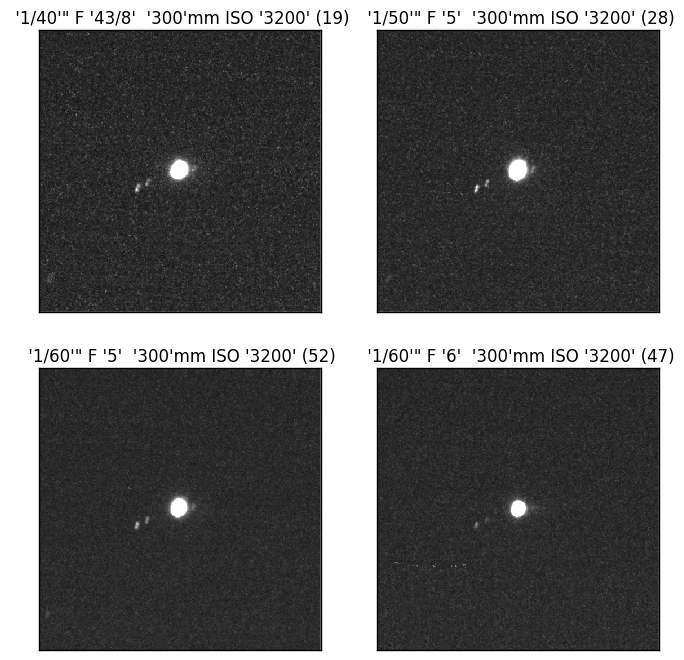

In [18]:
n = len(stacks)
cols = np.sqrt(n)
rows = cols
if cols != int(cols):
    cols = np.ceil(cols)
    rows = np.ceil(n/cols)
    
    while rows > cols:
        cols += 1
        rows = np.ceil(n/cols)
        
cols = int(cols)
rows = int(rows)

k = 4

figure(figsize=(4*cols,k*rows))
ds = stacks.keys()
ds.sort()
for i,d_i in enumerate(ds):
    print n_frames[d_i], d_i
    subplot(rows,cols,i+1)
    imshow(stacks_clean[d_i], cmap=cm.gray, vmin=0 , vmax=3000, interpolation='none')
    toks = d_i.replace(")","").split(",")
    ddisp = '%s" F%s %smm ISO%s' % tuple([ toks[i] for i in [1,3,5,7]])
    title("%s (%d)" % (ddisp,n_frames[d_i]))
    xticks([])
    yticks([])
    
savefig("20170517_2_jupiter_stacks_culled.jpg", facecolor='grey')